In [1]:
import os
import pandas
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.utils import make_grid

plt.rcParams["savefig.bbox"] = 'tight'

In [2]:
class CNN_Cifar10(nn.Module):
    def __init__(self):
        super(CNN_Cifar10, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size= 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size= 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size= 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            # nn.Conv2d(128, 256, kernel_size= 3, stride=2, padding=1),
            # nn.BatchNorm2d(256),
            # nn.LeakyReLU(),
            # nn.Conv2d(256, 512, kernel_size= 3, stride=2, padding=1),
            # nn.BatchNorm2d(512),
            # nn.LeakyReLU(),
            nn.Flatten()
        )

        self.z_mean = nn.Linear(2048, 16)
        self.z_log_var = nn.Linear(2048, 16)

        self.decoder = nn.Sequential(
            nn.Linear(16, 2048),
            nn.Unflatten(1, (128, 4, 4)),
            # nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            # nn.BatchNorm2d(256),
            # nn.LeakyReLU(),
            # nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            # nn.BatchNorm2d(128),
            # nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),            
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 3, kernel_size= 3, padding= 1),
            nn.Tanh()
        )

    def forward(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)
        dec = self.decoder(lat)
        
        return dec, mu, lv

    def reparam(self, mu, lv):
        std = torch.exp(0.5 * lv)
        eps = torch.randn_like(std)
        return mu + std * eps

In [3]:
transform = transforms.Compose(
    [
        # transforms.RandomHorizontalFlip(),
        # transforms.CenterCrop(148),
        # transforms.Resize(64),
        transforms.ToTensor()
    ]
)

trainset = CIFAR10(root='/media/airesearch/khoibaocon/git/data', train=True, download=True, transform=transform)
train_dl = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=24)
validset = CIFAR10(root='/media/airesearch/khoibaocon/git/data', train=False, download=True, transform=transform)
valid_dl = DataLoader(validset, batch_size=64, shuffle=False, num_workers=24)

print(len(trainset), len(validset))
print(len(train_dl), len(valid_dl))

Files already downloaded and verified
Files already downloaded and verified
50000 10000
782 157


In [4]:
def gaussian_kls(mu, logvar):
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return torch.mean(kld_loss)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNN_Cifar10().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.005)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs*len(train_dl))

recon_loss = nn.MSELoss(reduction='none')

def loss_fn(recon_x, x):
    return torch.mean(torch.sum(recon_loss(recon_x, x), dim=(1,2,3)))

In [6]:
for epoch in range(epochs):
    model.train()
    tr_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        tr_total_loss["rec_loss"] += train_rec_loss.item()
        tr_total_loss["kl_loss"] += train_kl_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = {
            "rec_loss" : 0,
            "kl_loss" : 0
        }
        for valid_img, _ in tqdm(valid_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss["rec_loss"] += valid_rec_loss.item()
            va_total_loss["kl_loss"] += valid_kl_loss.item()

    print(f"Epoch: {epoch} - TrainRecLoss: {tr_total_loss['rec_loss']/len(train_dl)} - ValidRecLoss: {va_total_loss['rec_loss']/len(valid_dl)}")
    print(f"Epoch: {epoch} - TrainDivLoss: {tr_total_loss['kl_loss']/len(train_dl)} - ValidDivLoss: {va_total_loss['kl_loss']/len(valid_dl)}")

100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 85.56it/s]


Epoch: 0 - TrainRecLoss: 89.37097866516893 - ValidRecLoss: 65.13384586990259
Epoch: 0 - TrainDivLoss: 18.73964831972366 - ValidDivLoss: 18.575739004050092


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.23it/s]


Epoch: 1 - TrainRecLoss: 65.57179049518712 - ValidRecLoss: 62.62118632322664
Epoch: 1 - TrainDivLoss: 18.058356536318882 - ValidDivLoss: 18.331639344525186


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 82.01it/s]


Epoch: 2 - TrainRecLoss: 63.573928511051264 - ValidRecLoss: 61.885708292578435
Epoch: 2 - TrainDivLoss: 18.077875464163778 - ValidDivLoss: 17.80420981243158


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.36it/s]


Epoch: 3 - TrainRecLoss: 63.017798689625145 - ValidRecLoss: 61.60250412278874
Epoch: 3 - TrainDivLoss: 18.033445430228777 - ValidDivLoss: 17.94201963874185


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.33it/s]


Epoch: 4 - TrainRecLoss: 62.3839583335935 - ValidRecLoss: 60.96549377927355
Epoch: 4 - TrainDivLoss: 18.00325880757988 - ValidDivLoss: 18.03200523716629


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.98it/s]


Epoch: 5 - TrainRecLoss: 62.21301491973955 - ValidRecLoss: 61.550383379504936
Epoch: 5 - TrainDivLoss: 17.94928389010222 - ValidDivLoss: 18.181288494425974


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 85.86it/s]


Epoch: 6 - TrainRecLoss: 61.88343692984422 - ValidRecLoss: 61.45453174858336
Epoch: 6 - TrainDivLoss: 17.944607690777012 - ValidDivLoss: 17.958858720815865


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 86.12it/s]


Epoch: 7 - TrainRecLoss: 61.58932013645806 - ValidRecLoss: 60.91032533584886
Epoch: 7 - TrainDivLoss: 17.93965879913486 - ValidDivLoss: 17.534535790704616


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 82.96it/s]


Epoch: 8 - TrainRecLoss: 61.29678620340879 - ValidRecLoss: 61.72431017638771
Epoch: 8 - TrainDivLoss: 17.93418460611797 - ValidDivLoss: 17.004336806619243


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 80.51it/s]


Epoch: 9 - TrainRecLoss: 61.511674920006485 - ValidRecLoss: 60.888111478963474
Epoch: 9 - TrainDivLoss: 17.935319334649673 - ValidDivLoss: 17.53966522216797


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 82.80it/s]


Epoch: 10 - TrainRecLoss: 61.011164672539365 - ValidRecLoss: 59.48840300444585
Epoch: 10 - TrainDivLoss: 17.961283971586496 - ValidDivLoss: 18.339142611072322


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 81.49it/s]


Epoch: 11 - TrainRecLoss: 61.06196312282396 - ValidRecLoss: 60.841461035856014
Epoch: 11 - TrainDivLoss: 17.92123633821297 - ValidDivLoss: 17.8895625217705


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.33it/s]


Epoch: 12 - TrainRecLoss: 60.86052616051091 - ValidRecLoss: 61.40990914508795
Epoch: 12 - TrainDivLoss: 17.926206542402888 - ValidDivLoss: 18.388266897505257


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 81.95it/s]


Epoch: 13 - TrainRecLoss: 60.7189402909535 - ValidRecLoss: 60.607387834293824
Epoch: 13 - TrainDivLoss: 17.92551835296709 - ValidDivLoss: 18.33811716213348


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 81.49it/s]


Epoch: 14 - TrainRecLoss: 60.71429669704584 - ValidRecLoss: 59.84073114091424
Epoch: 14 - TrainDivLoss: 17.933945863143258 - ValidDivLoss: 18.560576821588405


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 82.04it/s]


Epoch: 15 - TrainRecLoss: 60.636913675176515 - ValidRecLoss: 60.508827476744436
Epoch: 15 - TrainDivLoss: 17.938467076977197 - ValidDivLoss: 17.379048098424438


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 79.21it/s]


Epoch: 16 - TrainRecLoss: 60.50935711092351 - ValidRecLoss: 59.848694187820335
Epoch: 16 - TrainDivLoss: 17.934913657205488 - ValidDivLoss: 17.65918919994573


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.46it/s]


Epoch: 17 - TrainRecLoss: 60.34947665085268 - ValidRecLoss: 59.98746296099037
Epoch: 17 - TrainDivLoss: 17.961643765344643 - ValidDivLoss: 17.493942163552447


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 81.59it/s]


Epoch: 18 - TrainRecLoss: 60.403819101240934 - ValidRecLoss: 60.01435674679507
Epoch: 18 - TrainDivLoss: 17.99852580731482 - ValidDivLoss: 18.668709712423336


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 84.03it/s]


Epoch: 19 - TrainRecLoss: 60.25143262370468 - ValidRecLoss: 60.048937900810486
Epoch: 19 - TrainDivLoss: 17.967585039260747 - ValidDivLoss: 17.759501499734867


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 87.37it/s]


Epoch: 20 - TrainRecLoss: 60.23186047058886 - ValidRecLoss: 59.5886164865676
Epoch: 20 - TrainDivLoss: 17.992211661375393 - ValidDivLoss: 18.081842543972524


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 81.61it/s]


Epoch: 21 - TrainRecLoss: 60.216657448302755 - ValidRecLoss: 59.98071060666613
Epoch: 21 - TrainDivLoss: 18.008338059915605 - ValidDivLoss: 17.843877998886594


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.03it/s]


Epoch: 22 - TrainRecLoss: 60.058886818263844 - ValidRecLoss: 59.519531808841
Epoch: 22 - TrainDivLoss: 17.98477889692692 - ValidDivLoss: 17.9065392974076


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 82.02it/s]


Epoch: 23 - TrainRecLoss: 60.14729687137067 - ValidRecLoss: 59.85842499459625
Epoch: 23 - TrainDivLoss: 17.984133366733563 - ValidDivLoss: 18.117977373159615


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 82.51it/s]


Epoch: 24 - TrainRecLoss: 60.10156523663065 - ValidRecLoss: 59.442247840249614
Epoch: 24 - TrainDivLoss: 18.025579506174072 - ValidDivLoss: 18.07993487947306


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 82.79it/s]


Epoch: 25 - TrainRecLoss: 59.84682602162861 - ValidRecLoss: 60.04395221297149
Epoch: 25 - TrainDivLoss: 18.017335564888956 - ValidDivLoss: 17.28592820380144


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 82.13it/s]


Epoch: 26 - TrainRecLoss: 59.98473120101578 - ValidRecLoss: 60.217304861469636
Epoch: 26 - TrainDivLoss: 18.011910653175295 - ValidDivLoss: 17.81889045618142


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.27it/s]


Epoch: 27 - TrainRecLoss: 59.969240149573594 - ValidRecLoss: 60.4111212955159
Epoch: 27 - TrainDivLoss: 18.029100213209382 - ValidDivLoss: 17.39655694536343


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 86.74it/s]


Epoch: 28 - TrainRecLoss: 59.82064718358657 - ValidRecLoss: 60.25503340800097
Epoch: 28 - TrainDivLoss: 18.010811015468118 - ValidDivLoss: 17.5290661344103


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 85.40it/s]


Epoch: 29 - TrainRecLoss: 59.70435384472313 - ValidRecLoss: 58.765453241433306
Epoch: 29 - TrainDivLoss: 18.027549285108172 - ValidDivLoss: 18.91056222368957


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.91it/s]


Epoch: 30 - TrainRecLoss: 59.70934140041966 - ValidRecLoss: 58.780332115805074
Epoch: 30 - TrainDivLoss: 18.012687797741513 - ValidDivLoss: 18.421015769812712


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 82.37it/s]


Epoch: 31 - TrainRecLoss: 59.61415499616462 - ValidRecLoss: 59.13997975732111
Epoch: 31 - TrainDivLoss: 18.01564574912381 - ValidDivLoss: 18.134791088711683


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 84.34it/s]


Epoch: 32 - TrainRecLoss: 59.61333397282359 - ValidRecLoss: 59.02143889020203
Epoch: 32 - TrainDivLoss: 18.020873360011887 - ValidDivLoss: 18.085082764838152


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 86.00it/s]


Epoch: 33 - TrainRecLoss: 59.495346464464426 - ValidRecLoss: 58.646706307769584
Epoch: 33 - TrainDivLoss: 18.059826950892766 - ValidDivLoss: 18.38168984917319


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 82.15it/s]


Epoch: 34 - TrainRecLoss: 59.53004847280205 - ValidRecLoss: 58.89977876699654
Epoch: 34 - TrainDivLoss: 18.043518217628264 - ValidDivLoss: 18.30324972359238


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.88it/s]


Epoch: 35 - TrainRecLoss: 59.5004763737359 - ValidRecLoss: 60.132103427959855
Epoch: 35 - TrainDivLoss: 18.05795169303484 - ValidDivLoss: 17.6578528288823


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.84it/s]


Epoch: 36 - TrainRecLoss: 59.46756341939082 - ValidRecLoss: 59.04916692843103
Epoch: 36 - TrainDivLoss: 18.059839797446795 - ValidDivLoss: 18.24317206850477


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.04it/s]


Epoch: 37 - TrainRecLoss: 59.386157569982814 - ValidRecLoss: 59.565393532917
Epoch: 37 - TrainDivLoss: 18.072740069435685 - ValidDivLoss: 17.793687200849984


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.31it/s]


Epoch: 38 - TrainRecLoss: 59.35094143606513 - ValidRecLoss: 59.27980447271067
Epoch: 38 - TrainDivLoss: 18.064802169799805 - ValidDivLoss: 18.298812683980177


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 80.95it/s]


Epoch: 39 - TrainRecLoss: 59.384291675694456 - ValidRecLoss: 59.23647145556796
Epoch: 39 - TrainDivLoss: 18.057076339526553 - ValidDivLoss: 18.07979289741273


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 81.98it/s]


Epoch: 40 - TrainRecLoss: 59.27559555034198 - ValidRecLoss: 60.64504227364898
Epoch: 40 - TrainDivLoss: 18.09526253722208 - ValidDivLoss: 17.77868698508876


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 82.06it/s]


Epoch: 41 - TrainRecLoss: 59.45650251930022 - ValidRecLoss: 58.86250798413708
Epoch: 41 - TrainDivLoss: 18.035786126275806 - ValidDivLoss: 18.04883495257918


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 82.86it/s]


Epoch: 42 - TrainRecLoss: 59.22875234111191 - ValidRecLoss: 59.265413612317126
Epoch: 42 - TrainDivLoss: 18.06690695340676 - ValidDivLoss: 17.668637160282984


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 86.12it/s]


Epoch: 43 - TrainRecLoss: 59.31620891990564 - ValidRecLoss: 59.684943351016685
Epoch: 43 - TrainDivLoss: 18.058765040639113 - ValidDivLoss: 17.485738912205786


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.66it/s]


Epoch: 44 - TrainRecLoss: 59.280510187758814 - ValidRecLoss: 58.47749848578386
Epoch: 44 - TrainDivLoss: 18.09049395588048 - ValidDivLoss: 18.572381438723035


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 82.56it/s]


Epoch: 45 - TrainRecLoss: 59.13758733998174 - ValidRecLoss: 59.63190450486104
Epoch: 45 - TrainDivLoss: 18.070366042349345 - ValidDivLoss: 17.933204480796864


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 85.25it/s]


Epoch: 46 - TrainRecLoss: 59.23159351983034 - ValidRecLoss: 58.96197453881525
Epoch: 46 - TrainDivLoss: 18.072501333778167 - ValidDivLoss: 18.93899013737964


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 86.03it/s]


Epoch: 47 - TrainRecLoss: 59.17169508482794 - ValidRecLoss: 59.625047452890186
Epoch: 47 - TrainDivLoss: 18.05424034138165 - ValidDivLoss: 17.88863239166843


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 82.82it/s]


Epoch: 48 - TrainRecLoss: 59.218757580613236 - ValidRecLoss: 59.54655169833238
Epoch: 48 - TrainDivLoss: 18.055029293460308 - ValidDivLoss: 17.792084529901008


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 86.13it/s]


Epoch: 49 - TrainRecLoss: 59.078736561338616 - ValidRecLoss: 59.44045342609381
Epoch: 49 - TrainDivLoss: 18.082261056241478 - ValidDivLoss: 17.806282079903184


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 81.56it/s]


Epoch: 50 - TrainRecLoss: 59.087829160568354 - ValidRecLoss: 59.90783042664741
Epoch: 50 - TrainDivLoss: 18.070874553202362 - ValidDivLoss: 17.85636300493957


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 82.17it/s]


Epoch: 51 - TrainRecLoss: 58.950615665796775 - ValidRecLoss: 59.53363872941132
Epoch: 51 - TrainDivLoss: 18.088507796187535 - ValidDivLoss: 17.624275596278487


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 81.30it/s]


Epoch: 52 - TrainRecLoss: 58.95430912203191 - ValidRecLoss: 59.238679849418105
Epoch: 52 - TrainDivLoss: 18.059123609986756 - ValidDivLoss: 17.933858191131787


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.40it/s]


Epoch: 53 - TrainRecLoss: 59.05831624784738 - ValidRecLoss: 58.37313424857559
Epoch: 53 - TrainDivLoss: 18.066795446683685 - ValidDivLoss: 18.574394068140894


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 82.61it/s]


Epoch: 54 - TrainRecLoss: 58.93756752306848 - ValidRecLoss: 58.89419118310236
Epoch: 54 - TrainDivLoss: 18.107316680576492 - ValidDivLoss: 18.154606327129777


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 86.57it/s]


Epoch: 55 - TrainRecLoss: 58.89132552378623 - ValidRecLoss: 59.07058254169051
Epoch: 55 - TrainDivLoss: 18.1037245967504 - ValidDivLoss: 17.851016876803843


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.50it/s]


Epoch: 56 - TrainRecLoss: 58.91393959552735 - ValidRecLoss: 58.742485678120026
Epoch: 56 - TrainDivLoss: 18.06929055382224 - ValidDivLoss: 18.115892337386015


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 80.93it/s]


Epoch: 57 - TrainRecLoss: 58.95955427223459 - ValidRecLoss: 58.99738175701943
Epoch: 57 - TrainDivLoss: 18.07371319773252 - ValidDivLoss: 18.13284168121921


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 67.24it/s]


Epoch: 58 - TrainRecLoss: 58.984427064276105 - ValidRecLoss: 59.273564940045596
Epoch: 58 - TrainDivLoss: 18.093363822878473 - ValidDivLoss: 18.107596099756325


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 82.09it/s]


Epoch: 59 - TrainRecLoss: 58.912590841503096 - ValidRecLoss: 58.463871050792136
Epoch: 59 - TrainDivLoss: 18.08758094426616 - ValidDivLoss: 18.739855310719484


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 82.83it/s]


Epoch: 60 - TrainRecLoss: 58.850745603556526 - ValidRecLoss: 58.78658236363891
Epoch: 60 - TrainDivLoss: 18.079322807624212 - ValidDivLoss: 18.30059586057238


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.51it/s]


Epoch: 61 - TrainRecLoss: 58.91164181116597 - ValidRecLoss: 58.84720463357913
Epoch: 61 - TrainDivLoss: 18.093271272566618 - ValidDivLoss: 18.27682595951542


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 84.30it/s]


Epoch: 62 - TrainRecLoss: 58.900319648215834 - ValidRecLoss: 59.88415692566307
Epoch: 62 - TrainDivLoss: 18.083237035805002 - ValidDivLoss: 17.771373906712622


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 81.74it/s]


Epoch: 63 - TrainRecLoss: 58.87858270318307 - ValidRecLoss: 59.19826495419642
Epoch: 63 - TrainDivLoss: 18.089040112312492 - ValidDivLoss: 17.811068018530584


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 86.80it/s]


Epoch: 64 - TrainRecLoss: 58.874842885205204 - ValidRecLoss: 59.810539682959295
Epoch: 64 - TrainDivLoss: 18.093590116866714 - ValidDivLoss: 17.75644087335866


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 85.03it/s]


Epoch: 65 - TrainRecLoss: 58.81025950439141 - ValidRecLoss: 58.521489841922836
Epoch: 65 - TrainDivLoss: 18.12680015905434 - ValidDivLoss: 18.278526123921583


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.96it/s]


Epoch: 66 - TrainRecLoss: 58.82525444030762 - ValidRecLoss: 58.93621347512409
Epoch: 66 - TrainDivLoss: 18.112417806444874 - ValidDivLoss: 18.25458124488782


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 81.92it/s]


Epoch: 67 - TrainRecLoss: 58.72195049685895 - ValidRecLoss: 58.78129162150584
Epoch: 67 - TrainDivLoss: 18.0889745965943 - ValidDivLoss: 17.98380226086659


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 84.00it/s]


Epoch: 68 - TrainRecLoss: 58.739484879671764 - ValidRecLoss: 58.689656154365295
Epoch: 68 - TrainDivLoss: 18.10553628770287 - ValidDivLoss: 18.183970906931883


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 85.86it/s]


Epoch: 69 - TrainRecLoss: 58.77695481185718 - ValidRecLoss: 58.914031933827005
Epoch: 69 - TrainDivLoss: 18.08914590674593 - ValidDivLoss: 18.03513620461628


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 80.00it/s]


Epoch: 70 - TrainRecLoss: 58.79353179346265 - ValidRecLoss: 58.471828217719015
Epoch: 70 - TrainDivLoss: 18.091038247813348 - ValidDivLoss: 18.53845267083235


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 79.09it/s]


Epoch: 71 - TrainRecLoss: 58.75890188875711 - ValidRecLoss: 59.30387193230307
Epoch: 71 - TrainDivLoss: 18.11974238129833 - ValidDivLoss: 17.62545662169244


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 81.11it/s]


Epoch: 72 - TrainRecLoss: 58.71675084497008 - ValidRecLoss: 59.482513160462595
Epoch: 72 - TrainDivLoss: 18.102062713154748 - ValidDivLoss: 17.666585071830994


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 82.64it/s]


Epoch: 73 - TrainRecLoss: 58.63005399094213 - ValidRecLoss: 58.497681101416326
Epoch: 73 - TrainDivLoss: 18.148906737032448 - ValidDivLoss: 18.31228058201492


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.64it/s]


Epoch: 74 - TrainRecLoss: 58.70733834288614 - ValidRecLoss: 60.34425276252115
Epoch: 74 - TrainDivLoss: 18.118519561065128 - ValidDivLoss: 18.104760516221358


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 77.63it/s]


Epoch: 75 - TrainRecLoss: 58.63199710602041 - ValidRecLoss: 60.173408799869996
Epoch: 75 - TrainDivLoss: 18.07855856083238 - ValidDivLoss: 17.825945264974216


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 76.54it/s]


Epoch: 76 - TrainRecLoss: 58.68660973648891 - ValidRecLoss: 58.68244251324113
Epoch: 76 - TrainDivLoss: 18.089818122746696 - ValidDivLoss: 18.67968975966144


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 81.29it/s]


Epoch: 77 - TrainRecLoss: 58.646188662789974 - ValidRecLoss: 58.04434685190772
Epoch: 77 - TrainDivLoss: 18.101467659406346 - ValidDivLoss: 18.93375961643875


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 77.43it/s]


Epoch: 78 - TrainRecLoss: 58.594757348375246 - ValidRecLoss: 59.16657978713892
Epoch: 78 - TrainDivLoss: 18.111572885147446 - ValidDivLoss: 17.798881737289914


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 78.03it/s]


Epoch: 79 - TrainRecLoss: 58.622359692897945 - ValidRecLoss: 59.07409541622089
Epoch: 79 - TrainDivLoss: 18.11049101846602 - ValidDivLoss: 18.782555221752


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 71.50it/s]


Epoch: 80 - TrainRecLoss: 58.57764316763719 - ValidRecLoss: 58.72492064943739
Epoch: 80 - TrainDivLoss: 18.131813081024248 - ValidDivLoss: 18.257602278594


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 76.15it/s]


Epoch: 81 - TrainRecLoss: 58.602746558616225 - ValidRecLoss: 59.07973149779496
Epoch: 81 - TrainDivLoss: 18.113958614866448 - ValidDivLoss: 18.12921864211939


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 68.41it/s]


Epoch: 82 - TrainRecLoss: 58.55885566165075 - ValidRecLoss: 60.225621703324045
Epoch: 82 - TrainDivLoss: 18.134543948161326 - ValidDivLoss: 17.40341615373162


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 74.68it/s]


Epoch: 83 - TrainRecLoss: 58.544794433866926 - ValidRecLoss: 58.630214812649285
Epoch: 83 - TrainDivLoss: 18.130076727903713 - ValidDivLoss: 18.895507132171826


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 74.65it/s]


Epoch: 84 - TrainRecLoss: 58.576388195652484 - ValidRecLoss: 59.49692246260916
Epoch: 84 - TrainDivLoss: 18.10943757664517 - ValidDivLoss: 17.820989122815952


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 72.19it/s]


Epoch: 85 - TrainRecLoss: 58.53453944955031 - ValidRecLoss: 59.207316453289835
Epoch: 85 - TrainDivLoss: 18.13882671658645 - ValidDivLoss: 17.54076086639599


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 71.12it/s]


Epoch: 86 - TrainRecLoss: 58.61767131776151 - ValidRecLoss: 58.47496883125062
Epoch: 86 - TrainDivLoss: 18.14266826307682 - ValidDivLoss: 18.44917795460695


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 74.83it/s]


Epoch: 87 - TrainRecLoss: 58.49799795711742 - ValidRecLoss: 58.92135673571544
Epoch: 87 - TrainDivLoss: 18.136514707599453 - ValidDivLoss: 17.816430207270727


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 72.41it/s]


Epoch: 88 - TrainRecLoss: 58.507647126531964 - ValidRecLoss: 59.566362587509644
Epoch: 88 - TrainDivLoss: 18.115009734697658 - ValidDivLoss: 17.963606828337262


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 71.89it/s]


Epoch: 89 - TrainRecLoss: 58.58042982838038 - ValidRecLoss: 58.78999931189664
Epoch: 89 - TrainDivLoss: 18.16635114518578 - ValidDivLoss: 18.108554232652022


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 81.64it/s]


Epoch: 90 - TrainRecLoss: 58.469640619614545 - ValidRecLoss: 59.71518590647703
Epoch: 90 - TrainDivLoss: 18.12411205847855 - ValidDivLoss: 17.39089963390569


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 84.78it/s]


Epoch: 91 - TrainRecLoss: 58.539430510967286 - ValidRecLoss: 58.62220948820661
Epoch: 91 - TrainDivLoss: 18.110060516220834 - ValidDivLoss: 18.619722621456074


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.57it/s]


Epoch: 92 - TrainRecLoss: 58.51480124002832 - ValidRecLoss: 59.00982080447446
Epoch: 92 - TrainDivLoss: 18.144082240131507 - ValidDivLoss: 17.88602239766698


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 78.74it/s]


Epoch: 93 - TrainRecLoss: 58.46407113721609 - ValidRecLoss: 58.74428159871678
Epoch: 93 - TrainDivLoss: 18.127605265058826 - ValidDivLoss: 18.29242719662417


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 82.34it/s]


Epoch: 94 - TrainRecLoss: 58.53375041698251 - ValidRecLoss: 58.98492516681647
Epoch: 94 - TrainDivLoss: 18.119993075690306 - ValidDivLoss: 17.877852701077796


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 82.41it/s]


Epoch: 95 - TrainRecLoss: 58.3560874870671 - ValidRecLoss: 59.4793410817529
Epoch: 95 - TrainDivLoss: 18.135171636596056 - ValidDivLoss: 17.555245697118675


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 81.46it/s]


Epoch: 96 - TrainRecLoss: 58.37953397258163 - ValidRecLoss: 59.58402791600319
Epoch: 96 - TrainDivLoss: 18.14671289341529 - ValidDivLoss: 17.285297029337308


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 81.22it/s]


Epoch: 97 - TrainRecLoss: 58.40257047082457 - ValidRecLoss: 58.99254588716349
Epoch: 97 - TrainDivLoss: 18.124492733070003 - ValidDivLoss: 17.786624446796004


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 80.11it/s]


Epoch: 98 - TrainRecLoss: 58.494387229080395 - ValidRecLoss: 58.820246192300395
Epoch: 98 - TrainDivLoss: 18.147653296780405 - ValidDivLoss: 18.314965642941225


100%|██████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 80.95it/s]

Epoch: 99 - TrainRecLoss: 58.54933500655777 - ValidRecLoss: 58.63270350170743
Epoch: 99 - TrainDivLoss: 18.1333301451505 - ValidDivLoss: 18.359282742640016


In [7]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

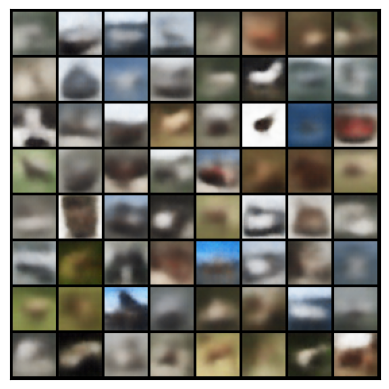

In [8]:
test_input, _ = next(iter(valid_dl))
test_input = test_input.to(device)

model.eval()
with torch.no_grad():
    recons, _, _ = model(test_input)

grid = make_grid(recons)
show(grid)

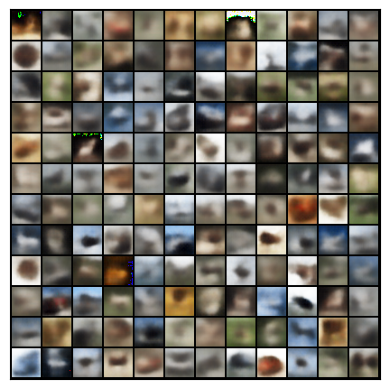

In [9]:
z = torch.randn(144, 16).to(device)

samples = model.decoder(z)

grid = make_grid(samples, nrow=12)
show(grid)